## Building an image classifier using Transfer learning-Convnet in Pytorch for dog vs cat classification

In [1]:
data_dir = "E:\Workspace\Data\cat_dog\data"
import warnings
warnings.filterwarnings('ignore')

### Imports 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import torch.nn.functional as F

### Transformations to apply on the dataset.

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(299, scale=(0.96, 1.0), ratio=(0.95, 1.05)), # 299 as we will use Inception model.
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize([299,299]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Reading image from the data folder and constructing pytorch dataloaders

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

['cats', 'dogs']
Train image size: 23000
Validation image size: 2000


In [5]:
trainloader = dataloaders.get('train')
valloader = dataloaders.get('val')

### Getting the pre-trained model Inception model from Pytorch repo.

In [6]:
# using the inception model

inception = torchvision.models.inception_v3(pretrained=True)
print(inception)

# turning of all the gradient.
for param in inception.parameters():
    param.requires_grad = False

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

)


### Function to show how many trainable parameters are there in the model.

In [7]:
def how_many_params_to_learn(model):
    
    for param in model.parameters():
        if  param.requires_grad:
            print(param.shape)

In [8]:
# no parameters
how_many_params_to_learn(inception)

### Removing the last layer of the model and adding new layer as per our no of classes.

In [9]:
# we have to change the last layer to give 2 outputs.
num_classes  = 2
# for auxilary loss.
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

# for final loss
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [10]:
how_many_params_to_learn(inception)

torch.Size([2, 768])
torch.Size([2])
torch.Size([2, 2048])
torch.Size([2])


In [11]:
# viewing some sample shapes
i = iter(trainloader)
images , labels = i.next()

print(images.shape)
print(images[0].shape)
print(labels)

torch.Size([32, 3, 299, 299])
torch.Size([3, 299, 299])
tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 0])


### Using the model and defining loss function and optimizer to use.

In [12]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

### Evaluation metric function to print the accuracy of the dataset.

In [13]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

### Learning loop.
We will be using early stopping technique so the we are able to get better accuracy.

Min loss 1.01
Iteration: 0/1563, Loss: 1.01
Min loss 0.95
Min loss 0.84
Min loss 0.76
Min loss 0.71
Min loss 0.69
Min loss 0.68
Min loss 0.67
Min loss 0.67
Min loss 0.67
Min loss 0.62
Min loss 0.58
Min loss 0.49
Min loss 0.44
Min loss 0.42
Min loss 0.41
Min loss 0.38
Min loss 0.38
Min loss 0.36
Min loss 0.31
Min loss 0.25
Min loss 0.21
Min loss 0.19
Min loss 0.19
Iteration: 100/1563, Loss: 0.26
Min loss 0.18
Min loss 0.17
Min loss 0.17
Min loss 0.17
Min loss 0.17
Min loss 0.17
Min loss 0.12
Min loss 0.12
Iteration: 200/1563, Loss: 0.15
Min loss 0.12
Min loss 0.11
Min loss 0.10
Min loss 0.10
Min loss 0.10
Min loss 0.09
Iteration: 300/1563, Loss: 0.23
Min loss 0.08
Min loss 0.08
Min loss 0.05
Iteration: 400/1563, Loss: 0.19
Min loss 0.04
Iteration: 500/1563, Loss: 0.06
Iteration: 600/1563, Loss: 0.15
Min loss 0.04
Min loss 0.03
Min loss 0.03
Iteration: 700/1563, Loss: 0.16
Epoch: 0/1, Test acc: 94.30, Train acc: 95.05


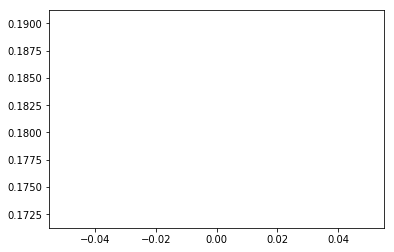

In [14]:
loss_epoch_arr = []
max_epochs = 1
batch_size = 32
min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(valloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

### Loading the best model i.e the  model that gives min error.

In [17]:
inception.load_state_dict(best_model)

# displaying the accuracy score.
print(evaluation_inception(trainloader, inception), evaluation_inception(valloader, inception))

95.84347826086956 95.35


In [18]:
# saving the model to local drive so that we can reload it and use it for inference
PATH = "E:\Workspace\Saved_models\model.pth"
torch.save(inception.state_dict(), PATH)

### Loading the model from local storage to make inference

In [19]:
inception.load_state_dict(torch.load(PATH))
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

### Loading the test data and making pytorch dataloader

In [20]:
transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    ])

testset = torchvision.datasets.ImageFolder(data_dir+'/test',transform=transform_test)
testloader = torch.utils.data.DataLoader(testset,batch_size= 1,shuffle=True)

In [21]:
testloader.dataset

Dataset ImageFolder
    Number of datapoints: 12500
    Root Location: E:\Workspace\Data\cat_dog\data/test
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(299, 299), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None

### Function to show an image from tensor

In [22]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Making inference from test data.

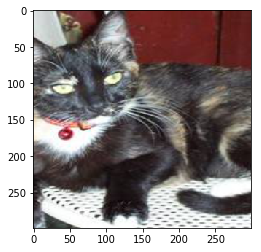

97.6 %  its a Cat


In [28]:
inception.to('cpu')
classes = ('Cat','Dog')
ind = iter(testloader)
images,labels = ind.next()
for i in images:
    imshow(i)

softMax = nn.Softmax(dim = 1)
preds = softMax(inception(images))
preds = preds.detach().numpy()
i = preds.argmax()
p = round(preds.max() * 100,2)

print(p,'%  its a',classes[i])